# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias, Q. Bertrand, N. Gazagnadou

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated proximal gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 6th of october at 21:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 30 septembre 2019**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Sofiane"
ln1 = "ENNADIR"
fn2 = "Mohammed-Amine"
ln2 = "ABBOUDI"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_ennadir_sofiane_and_abboudi_mohammed-amine.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Generating sparse coefficients

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

np.random.seed(42) ## To have the same results as my collegue

from time import time

Text(0.5, 1.0, 'Parameters / Coefficients')

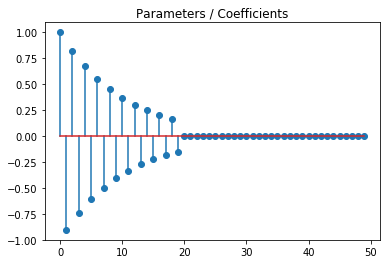

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [6]:
A, b = simu_linreg(coefs);
# A, b = simu_logreg(coefs);  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{\lambda\,R}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization: $\lambda\, R(z) = \frac{\lambda}{2} \|z\|_2^2$
- L1 penalization: $\lambda\, R(z) = \lambda\|z|\|_1$

where $\lambda \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $\lambda \, R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
     <li>Hint: for the prox of the L1 norm you can either use the formula from the course or rewrite it with np.max and np.sign functions
    </li>
      <li>Visualize the identity function and the proximity operators of the L2 and L1 on the real axis
    </li>
    </ul>
</div>

In [7]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    
    # First Method
    '''
    if x > lmbd : 
        z = x - lmbd
        
    elif x < lmbd and x > - lmbd:
        z = 0
        
    else:
        z = lmbd + x
    '''
    
    # Second Method (Easier to implement)
    z = np.sign(x) * np.maximum(np.abs(x) - lmbd, 0.)
    return z

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    z = lmbd * (np.sum(np.abs(x)))
    return z

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    z = np.maximum(np.sum(x**2) - lmbd, 0) * (x/np.sum(x**2))
    return z

def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    z = (lmbd/2) * (np.sum(x**2))
    return z

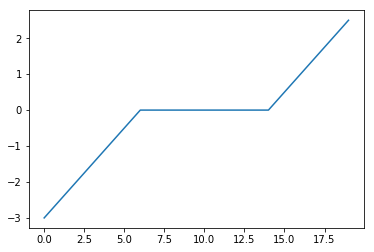

In [8]:
lmbd = 2.
x = np.arange(-5,5,step = 0.5)
plt.plot(prox_L1(x, lmbd))

Text(0.5, 1.0, 'Plotting L_1 and L_2 for different lambdas')

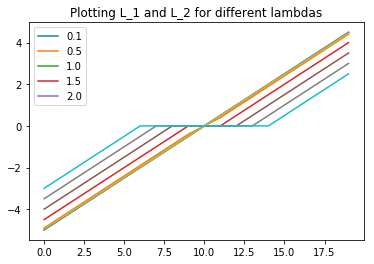

In [9]:
# Plots TODO

x = np.arange(-5,5,step = 0.5)
lmbds = [.1,.5,1.,1.5,2.]
for lmbd in lmbds:
    plt.plot(prox_L2(x, lmbd))
    plt.plot(prox_L1(x, lmbd))
plt.legend(lmbds)
plt.title('Plotting L_1 and L_2 for different lambdas')

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

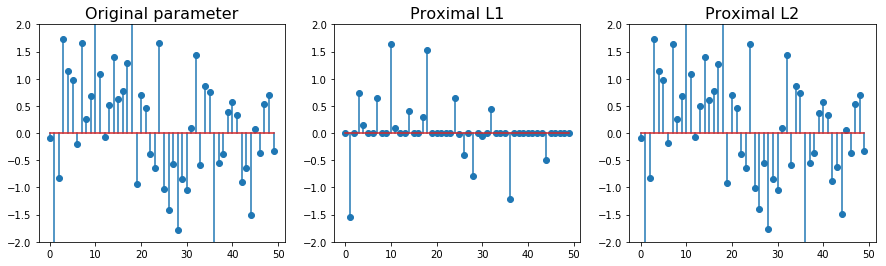

In [10]:
x = randn(n_features)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

<div>
    <b> Comment : </b>
            The Proximal L2 gives a much better approximation of our x regardless of the parameter Lambda, while the Proximal L1 only gives good results when the Lambda is small. That means that L2 is basically the appropriate one to be used for our case. 
</div>

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ is prox friendly.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A^\top = [a_1,\ldots, a_n] \in \mathbb{R}^{d \times n}$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient $\nabla f$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these loss functions are correct by numerically checking their ouputs</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

#### The kth element of the gradient of the linear regression loss function can be written as : 
$$\frac{\partial}{\partial x_k} \frac{1}{2n}(b-Ax)^\top.(b-Ax)= \frac{1}{n}\sum_{i=1}^{n} \left( \left( \sum_{j=1}^{m} a_{ij}x_j\right) - b_i\right) (a_{ik})$$
#### In matrix notation : $$\nabla f(x) = \frac{1}{n} A^\top (Ax-b)$$

#### For logistic regression
$$ \frac{\partial}{\partial x_k} \frac{1}{n} \sum_{i=1}^{n} log\left( 1+exp\left( -b_ia_i^\top x\right)\right) = \frac{1}{n} \sum_{i=1}^{n} \frac{-b_i.a_{ik}}{1+exp\left( -b_ia_i^\top x\right)}$$

In [51]:
# Completing the formulas based on the precedent explicitation of each formula
def loss_linreg(x):
    global A,b
    loss = L2_norm(b-np.matmul(A,x),1/len(b))
    return loss

def grad_linreg(x):
    global A,b
    return (1/len(b)) * (A.T)@(A@x-b)

def loss_logreg(x):
    return (1/len(b)) * np.sum(np.log(1+np.exp(-(b)*(A@x))))

def grad_logreg(x):
    
    grad_log_reg = np.zeros(A.shape[1])
    
    for j in range(A.shape[1]):
        grad_log_reg[j] = (1/len(b)) * np.sum((-A[:,j]*b)/(1+np.exp(b*(A@x))))

    return grad_log_reg

In [50]:
# Check our gradiant function -- Because we got a small value, that means that we are on a good path

from scipy.optimize import check_grad
print('The loss for the Linear Reg :', check_grad(loss_linreg, grad_linreg, x))

print('The loss for the Logistic Reg :', check_grad(loss_logreg, grad_logreg, x))

The loss for the Linear Reg : 7.3390907041e-06
The loss for the Logistic Reg : 2.00365479135e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_{\lambda R}$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the Lipschitz constant for linear and logistic regression losses. Remark: for the logistic regression, you should try to upper bound the second derivative</li>
      <li>Hint: the computation of the Lipschitz constant for the linear regression should be easy (cf course).
         But the computation of the Lipschitz constant for the logistic regression may be trickier. 
                 You may want to write $f$ as $f(x) = \frac{1}{n} \sum_i \phi(b_i a_i^\top x)$, and then show that $|\phi''| \leq \frac{1}{4}$.</li>
      <li>Implement functions that compute the Lipschitz constant for both cases (linear and logistic regression). Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (Be careful with the norm you chose! Read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD (Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms.
       Note: PGD is sometimes called ISTA (Iterative Soft Thresholding Algorithm) and APGD is sometimes called FISTA (Fast ISTA)</li> 
    </ul>
</div>

In [13]:
from numpy import linalg as LA

**For calculating the smoothness factor of f, we can easily show that** $ \| \nabla ^2 f(x) \|_2 \leq L $

**In the case of linear regression**  : $ \nabla ^2 f(x) = \frac{1}{n} A^\top A$, the hessian is given by the following : $\| \nabla ^2 f(x) \|_2 = \left(\lambda_{max} \left(\nabla ^2 f(x)^\top \nabla ^2 f(x)\right)\right)^{\frac{1}{2}}$

We can therefore bound $\frac{1}{L}$ by $\frac{1}{\lambda_{max} \left(\nabla ^2 f(x)^\top \nabla ^2 f(x)\right)}$

**For logistic regression**

$$ \frac{1}{L} \leq \frac{1}{\| \nabla ^2 f(x) \|_2} \leq \left(\lambda_{max} \left(\nabla ^2 f(x)^\top \nabla ^2 f(x)\right)\right)^{\frac{1}{2}}$$

**The hessian is expressed as follows**

$$ \nabla ^2 f(x) _{k,l} = \frac{1}{n} \sum_{i=1}^{n} |a_{ik}|.|a_{il}|.|\phi''(b_i a_i^\top x)| \leq \frac{1}{4n} \sum_{i=1}^{n} |a_{ik}|.|a_{il}|$$

In [14]:
# TO BE COMPLETED

# Calculate the smoothness constant for least squares loss
def smoothness_const_linreg(A):
    """Lipschitz constant for least squares loss"""    
    H_linreg = (1/(A.shape[0])) * (np.matmul(A.T,A))
    L_linreg = np.sqrt(LA.eigvals(H_linreg.T@H_linreg).max())
    return L_linreg

# Calculate the smoothness constant for logistic loss    
def smoothness_const_logreg(A):
    """Lipschitz constant for logistic loss"""
    
    H = np.zeros((n_features,n_features))
    for j in range(n_features):
        for k in range(n_features):
            H[j,k] = np.sum(abs(A[:,j]*A[:,k]))/(4*A.shape[0])

    L_logreg = np.sqrt(LA.eigvals(H.T@H).max())
    return L_logreg
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbda=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbda)
    objectives.append(obj)
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        
        x = prox_R(x - 1/step * grad_f(x), lmbda/step) # Update x value based on the optimization formula
        
        obj = f(x) + R(x, lmbda)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [27]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbda=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbda)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        
        x_new = prox_R(z - 1/step * grad_f(z), lmbda/step) #Compute the new x_new
        t_new = (1+np.sqrt(1+4*t**2))/2 #Compute the new t_new
        z = x_new + (t-1)*(x_new-x)/t_new #Compute the z based on the optimization foruma
        
        x = x_new # keep the values to be used
        t = t_new
        
        obj = f(x) + R(x, lmbda)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the problem (linear regression or logistic regression) using the parameters given above. This can be done by using APGD with 1000 iterations and setting `x_true` to `coeffs`.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer you have computed. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [64]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
lmbd = 1e-2

In [65]:
# Executing the PGD algorithm and calculating the error relative to the theoretical minumum (coefs)

start = time()
X_output_PGD, Objectif, errors_pgd = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, smoothness_const_linreg(A), lmbda=lmbd, n_iter=n_iter,
         x_true=coefs, verbose=True)
end = time()
end-start

Lauching PGD solver...
   it    |   obj    |   err   
       0 | 6.98e-01 | 9.95e-01
      10 | 6.48e-01 | 9.62e-01
      20 | 6.31e-01 | 9.34e-01
      30 | 6.19e-01 | 9.08e-01
      40 | 6.10e-01 | 8.82e-01


0.015086889266967773

In [66]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
lmbd = 1e-2

# Executing the APGD algorithm and calculating the error relative to the theoretical minumum (coefs)

start = time()
X_output_APGD, Objectif, errors_apgd = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, smoothness_const_linreg(A), lmbda=lmbd, n_iter=n_iter,
         x_true=coefs, verbose=True)
end = time()
end-start

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 6.98e-01 | 9.95e-01
      10 | 6.27e-01 | 9.27e-01
      20 | 5.85e-01 | 8.06e-01
      30 | 5.51e-01 | 6.51e-01
      40 | 5.27e-01 | 4.90e-01


0.017193078994750977

In [67]:
x_PGD_1000, Objectif, errors_pgd1000 = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, smoothness_const_linreg(A), lmbda=lmbd, n_iter=1000, x_true=coefs, verbose=False)
x_APGD_1000, Objectif, errors_apgd1000 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, smoothness_const_linreg(A), lmbda=lmbd, n_iter=1000, x_true=coefs, verbose=False)

In [68]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
lmbd = 1e-2

In [69]:
# Executing the PGD algorithm and calculating the error relative 
# to the minimizer computed (after 1000 iterations)

start = time()
X_output_PGD, Objectif, errors_pgd1000 = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, smoothness_const_linreg(A), lmbda=lmbd, n_iter=n_iter,
         x_true=x_PGD_1000, verbose=True)
end = time()
end-start

Lauching PGD solver...
   it    |   obj    |   err   
       0 | 6.98e-01 | 9.95e-01
      10 | 6.48e-01 | 9.57e-01
      20 | 6.31e-01 | 9.24e-01
      30 | 6.19e-01 | 8.93e-01
      40 | 6.10e-01 | 8.63e-01


0.01775217056274414

In [70]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
lmbd = 1e-2

# Executing the APGD algorithm and calculating the error relative 
# to the minimizer computed (after 1000 iterations)

start = time()
X_output_APGD, Objectif, errors_apgd1000 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, smoothness_const_linreg(A), lmbda=lmbd, n_iter=n_iter,
         x_true=x_APGD_1000, verbose=True)
end = time()
end-start

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 6.98e-01 | 9.95e-01
      10 | 6.27e-01 | 9.20e-01
      20 | 5.85e-01 | 7.85e-01
      30 | 5.51e-01 | 6.11e-01
      40 | 5.27e-01 | 4.23e-01


0.01633310317993164

Text(0.5, 1.0, 'Plot of the rate of convergence of PGD algorithm')

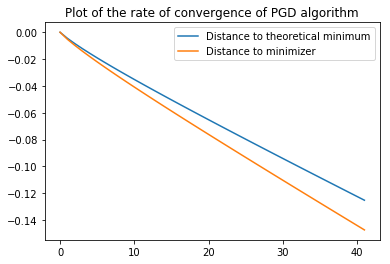

In [71]:
plt.plot(np.log(errors_pgd))
plt.plot(np.log(errors_pgd1000))
plt.legend(['Distance to theoretical minimum','Distance to minimizer'])
plt.title('Plot of the rate of convergence of PGD algorithm')

Text(0.5, 1.0, 'Plot of the rate of convergence of APGD algorithm')

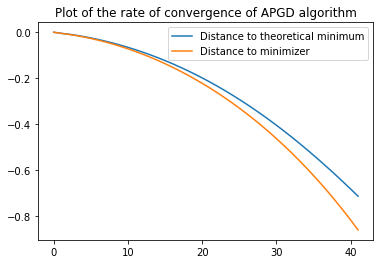

In [72]:
plt.plot(np.log(errors_apgd))
plt.plot(np.log(errors_apgd1000))
plt.legend(['Distance to theoretical minimum','Distance to minimizer'])
plt.title('Plot of the rate of convergence of APGD algorithm')

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of L2 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for L2 and L1 penalizations. Explain</li>
    </ul>
</div>

<div class="alert alert-primary" >
    <b>Question 1</b>:
        <ul>
            <li>Compare the solution you obtain with ista and fista with the true parameter coefs of the model. This can be done with plt.stem plots</li>
        </ul>
</div>

Text(0.5, 1.0, 'APGD')

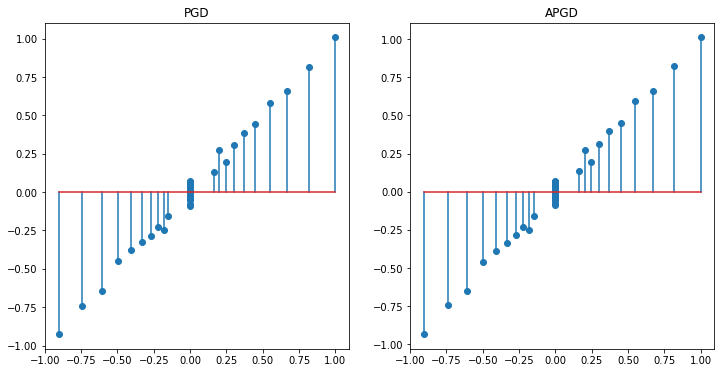

In [37]:
# stem plots related to the theoretical minumum (coefs) for both PGD & APDG

plt.figure(figsize=(12,6))
ax = plt.subplot(121)
plt.stem(coefs, X_output_PGD)
plt.title('PGD')

ax2 = plt.subplot(122)
plt.stem(coefs, X_output_APGD)
plt.title('APGD')

Text(0.5, 1.0, 'APGD')

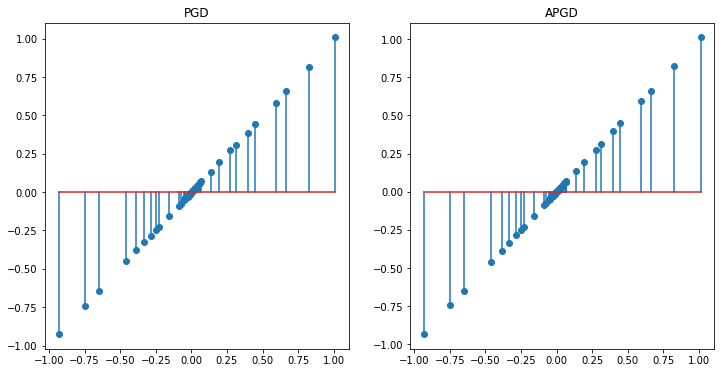

In [38]:
# stem plots related to the minimizer computed (after 1000 iterations) for both PGD & APDG

plt.figure(figsize=(12,6))
ax = plt.subplot(121)
plt.stem(x_PGD_1000, X_output_PGD)
plt.title('PGD')

ax2 = plt.subplot(122)
plt.stem(x_APGD_1000, X_output_APGD)
plt.title('APGD')

<div class="alert alert-primary" >
    <b>Question 2</b>:
        <ul>
            <li>In linear regression and logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.</li>
        </ul>
</div>

Text(0.5, 1.0, 'Effect of correlation -- Linear Regression')

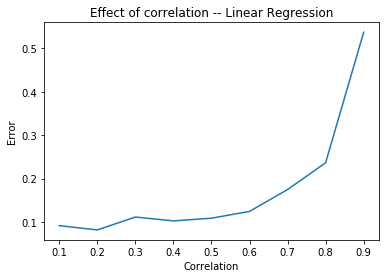

In [48]:
total_error = []
list_corr = [k/10 for k in range(1,10)]
for corr_unit in list_corr:
    A, b = simu_linreg(coefs, corr = corr_unit)
    X_output_PGD, Objectif, errors = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, smoothness_const_linreg(A), lmbda=lmbd, n_iter=n_iter,
             x_true=coefs, verbose=False)
    total_error.append(errors[-1])
    
plt.plot(list_corr, total_error)
plt.xlabel('Correlation')
plt.ylabel('Error')
plt.title('Effect of correlation -- Linear Regression')

Text(0.5, 1.0, 'Effect of correlation - Logistic Regression')

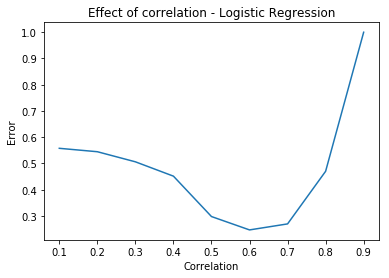

In [49]:
total_error = []
list_corr = [k/10 for k in range(1,10)]
for corr_unit in list_corr:
    A, b = simu_linreg(coefs, corr = corr_unit)
    X_output_PGD, Objectif, errors = PGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, smoothness_const_linreg(A), lmbda=lmbd, n_iter=n_iter,
             x_true=coefs, verbose=False)
    total_error.append(errors[-1])
    
plt.plot(list_corr, total_error)
plt.xlabel('Correlation')
plt.ylabel('Error')
plt.title('Effect of correlation - Logistic Regression')

<div>
<b>Comment :</b>When compiling our algorithm for a number of correlation values and try to see how it affects the optimization algorithm.
The effect of the correlation on the Error differs from the Linear and Logistic Regression. 
</div>
<b>Explanation : </b>


<div class="alert alert-primary" >
    <b>Question 3</b>:
        <ul>
            <li>In linear regression and logistic regression, study the influence of the level of L2 
              penalization on the performance of the optimization algorithms. Explain.</li>
        </ul>
</div>

Text(0.5, 1.0, 'Plotting Linreg errors with L2 penalization for different values of lambda')

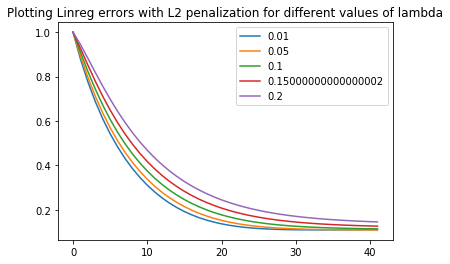

In [39]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40

lmbds = [1*1e-2,5*1e-2,1.*1e-1,1.5*1e-1,2e-1]
for lmbd in lmbds:
    X_output_PGD, Objectif, errors = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, smoothness_const_linreg(A), lmbda=lmbd, n_iter=n_iter,
         x_true=coefs, verbose=False)
    plt.plot(errors)
plt.legend(lmbds)
plt.title('Plotting Linreg errors with L2 penalization for different values of lambda')

For the case of linear regression we can see that the algorithm converges quite rapidly to approximateltely the same level of error. Although we note that the optimization algorithm's performance evolves in opposite fashion of the value of lambda. The L2 regularization is harsher, because it penalizes features from becoming too significant, even if they might be, and forces the model to enlarge its scope of explanation along more features than it otherwise would. The level of regularization serves as a proxy for how large one would want their feature coverage area.

Text(0.5, 1.0, 'Plotting Logreg errors with L2 penalization for different values of lambda')

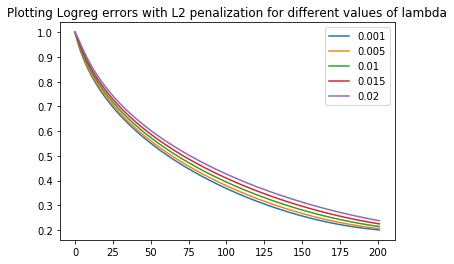

In [40]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 200

lmbds = [1*1e-3,5*1e-3,1.*1e-2,1.5*1e-2,2e-2]
for lmbd in lmbds:
    X_output_PGD, Objectif, errors = PGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, smoothness_const_logreg(A), lmbda=lmbd, n_iter=n_iter,
         x_true=coefs, verbose=False)
    plt.plot(errors)
plt.legend(lmbds)
plt.title('Plotting Logreg errors with L2 penalization for different values of lambda')

For logistic regression, we can see that the algorithm is still improving after 200 iterations, so the rate of convergence is higher than it is for linear regression. All the curves follow a very similar path, although they are still stratified with respect to the values of lambda. The lowest error corresponding to the lowest level of regularization.